<a href="https://colab.research.google.com/github/skhand17/cse598-Machine-Learning-Security-and-Fairness/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip drive/MyDrive/Project598/rsna-pneumonia-detection-challenge.zip > /dev/null

In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.7 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
labels = pd.read_csv("stage_2_train_labels.csv")

In [ ]:
labels[:5]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [ ]:
labels = labels.drop_duplicates("patientId")

In [ ]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed")


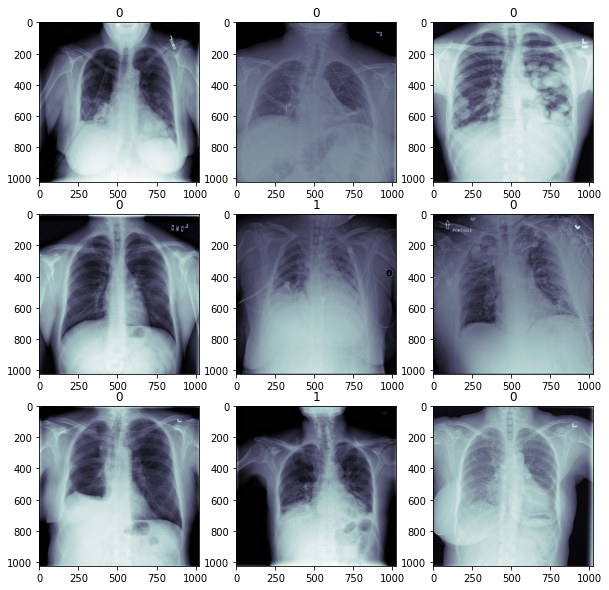

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(10,10))
counter = 0
for i in range(3):
  for j in range(3):
    patient_id  = labels.patientId.iloc[counter]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array

    label = labels["Target"].iloc[counter]

    axis[i][j].imshow(dcm, cmap="bone")
    axis[i][j].set_title(label)
    counter = counter + 1



In [ ]:
sums, sums_squared = 0 , 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
  patient_id  = labels.patientId.iloc[c]
  dcm_path = ROOT_PATH/patient_id
  dcm_path = dcm_path.with_suffix(".dcm")
  dcm = pydicom.read_file(dcm_path).pixel_array / 255

  dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

  label = labels.Target.iloc[c]

  train_or_val = "train" if c < 24000 else "val"

  current_save_path = SAVE_PATH/train_or_val/str(label)
  current_save_path.mkdir(parents=True, exist_ok=True)
  np.save(current_save_path/patient_id, dcm_array)

  normalizer = 224 * 224
  if train_or_val == "train" :
    sums +=np.sum(dcm_array) / normalizer
    sums_squared +=(dcm_array ** 2).sum() / normalizer
    


  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)


In [ ]:
mean, std

(0.4903962485384803, 0.24795070634161256)

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 22.5 MB/s eta 0:00:00


In [ ]:
pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 33.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.49, 0.248),
        transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9,1.1)),
        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.49], [0.248])
])


In [ ]:
train_dataset = torchvision.datasets.DatasetFolder("Processed/train/", loader=load_file,
                                                   extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder("Processed/val/", loader=load_file,
                                                 extensions="npy", transform=val_transforms)

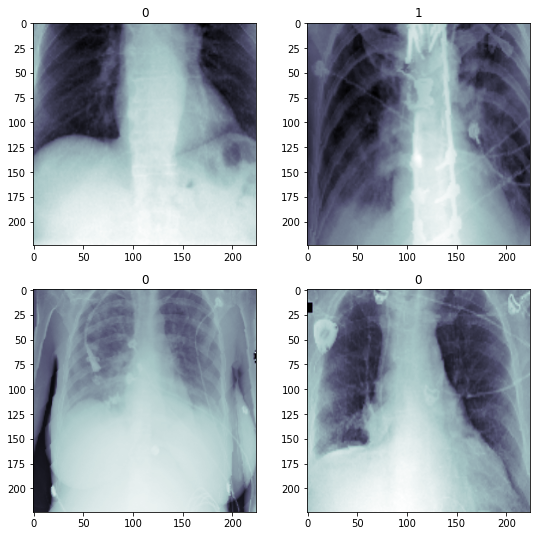

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9,9))
for i in range(2):
  for j in range(2):
    random_index = np.random.randint(0, 24000)
    x_ray, label = train_dataset[random_index]
    axis[i][j].imshow(x_ray[0], cmap="bone")
    axis[i][j].set_title(label)

In [ ]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False)

In [ ]:
np.unique(train_dataset.targets, return_counts=True)
np.unique(val_dataset.targets, return_counts=True)

(array([0, 1]), array([2079,  605]))

In [ ]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumoniaModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
        
    self.model = torchvision.models.resnet18()
    # change conv1 from 3 to 1 input channels
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
    # simple accuracy computation
    self.train_acc = torchmetrics.Accuracy(task="binary")
    self.val_acc = torchmetrics.Accuracy(task="binary")

  def forward(self, data):
    pred = self.model(data)
    return pred
    
  def training_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()  # Convert label to float (just needed for loss computation)
    pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
    loss = self.loss_fn(pred, label)  # Compute the loss
        
      # Log loss and batch accuracy
    self.log("Train Loss", loss)
    self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
    return loss
    
    
  def training_epoch_end(self, outs):
    # After one epoch compute the whole train_data accuracy
    self.log("Train Acc", self.train_acc.compute())
        
        
  def validation_step(self, batch, batch_idx):
    # Same steps as in the training_step
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

    loss = self.loss_fn(pred, label)
        
    # Log validation metrics
    self.log("Val Loss", loss)
    self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
    return loss
    
  def validation_epoch_end(self, outs):
    self.log("Val Acc", self.val_acc.compute())
    
  def configure_optimizers(self):
    #Caution! You always need to return a list here (just pack your optimizer into one :))
    return [self.optimizer]




In [ ]:
model = PneumoniaModel()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val Acc",
    save_top_k=10,
    mode="max"
)

In [ ]:
gpus = 1
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=35)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device);

In [ ]:
preds = []
labels = []

with torch.no_grad():
  for data, label in tqdm(val_dataset):
    data = data.to(device).float().unsqueeze(0)
    pred = torch.sigmoid(model(data)[0].cpu())
    preds.append(pred)
    labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(task="binary",num_classes=2)(preds, labels)

print(f"Val Accuracy {acc}")
print(f"Val Precision {precision}")
print(f"Val Recall {recall}")
print(f"Val Confusion Matrix {cm}")

Val Accuracy 0.8427720069885254
Val Precision 0.6691312193870544
Val Recall 0.5983471274375916
Val Confusion Matrix tensor([[1900,  179],
        [ 243,  362]])


In [ ]:
### Implementation of Class Activation Map:
%matplotlib
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 10.6 MB/s eta 0:00:00


In [ ]:
def load_file(path):
  return np.load(path).astype(np.float32)

val_transforms = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.49], [0.248])
])

val_dataset = torchvision.datasets.DatasetFolder("Processed/val/", loader=load_file,
                                                 extensions="npy", transform=val_transforms)


In [ ]:
### We need to extract the output of the last convolutional layer to check out on the Class Activation map
model_temp = torchvision.models.resnet18()
model_temp

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_temp.children()

<generator object Module.children at 0x7fd8fa9004a0>

In [ ]:
list(model_temp.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
torch.nn.Sequential(*list(model_temp.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
class PneumoniaModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features = 512, out_features=1)

    self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

  def forward(self, data):
    feature_map = self.feature_map(data)
    avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1,1))
    avg_output_flatten = torch.flatten(avg_pool_output)
    pred = self.model.fc(avg_output_flatten)
    return pred, feature_map

In [ ]:
model = PneumoniaModel()
model.eval();

In [ ]:
def cam(model, img):
  with torch.no_grad():
    pred, features = model(img.unsqueeze(0))
  
  features = features.reshape((512, 49))
  weight_param = list(model.model.fc.parameters())[0]
  weight = weight_param[0].detach()

  cam =  torch.matmul(weight, features)
  cam_img = cam.reshape(7,7).cpu()
  return cam_img, torch.sigmoid(pred)

In [ ]:
def visualize(img, cam, pred):
  img = img[0]
  cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

  fig, axis = plt.subplots(1,2,figsize=(10,7))
  axis[0].imshow(img, cmap="bone")
  axis[1].imshow(img, cmap="bone")
  axis[1].imshow(cam, alpha=0.5, cmap="jet")
  plt.title(pred > 0.5)

In [ ]:
img = val_dataset[-20][0]
activation_map, pred = cam(model, img)


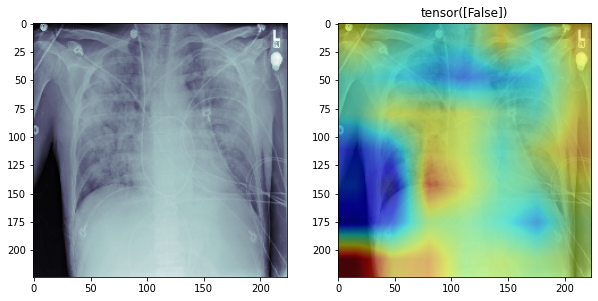

In [ ]:
visualize(img, activation_map, pred)

In [ ]:
### Now Implementing FGSM and PGD Attack
class PneumoniaModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
        
    self.model = torchvision.models.resnet18()
    # change conv1 from 3 to 1 input channels
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
    # simple accuracy computation
    self.train_acc = torchmetrics.Accuracy(task="binary")
    self.val_acc = torchmetrics.Accuracy(task="binary")

  def forward(self, data):
    pred = self.model(data)
    return pred
    
  def training_step(self, batch, batch_idx):
    x_ray, label = batch
    label = label.float()  # Convert label to float (just needed for loss computation)
    pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
    loss = self.loss_fn(pred, label)  # Compute the loss
        
      # Log loss and batch accuracy
    self.log("Train Loss", loss)
    self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
    return loss
    
    
  def training_epoch_end(self, outs):
    # After one epoch compute the whole train_data accuracy
    self.log("Train Acc", self.train_acc.compute())
        
        
  def validation_step(self, batch, batch_idx):
    # Same steps as in the training_step
    x_ray, label = batch
    label = label.float()
    pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

    loss = self.loss_fn(pred, label)
        
    # Log validation metrics
    self.log("Val Loss", loss)
    self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
    return loss
    
  def validation_epoch_end(self, outs):
    self.log("Val Acc", self.val_acc.compute())
    
  def configure_optimizers(self):
    #Caution! You always need to return a list here (just pack your optimizer into one :))
    return [self.optimizer]

In [ ]:
model = PneumoniaModel()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val Acc",
    save_top_k=10,
    mode="max"
)

In [ ]:
gpus = 1
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=35)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device);

In [ ]:
preds = []
labels = []

with torch.no_grad():
  for data, label in tqdm(val_dataset):
    data = data.to(device).float().unsqueeze(0)
    pred = torch.sigmoid(model(data)[0].cpu())
    preds.append(pred)
    labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(task="binary",num_classes=2)(preds, labels)

print(f"Val Accuracy {acc}")
print(f"Val Precision {precision}")
print(f"Val Recall {recall}")
print(f"Val Confusion Matrix {cm}")

Val Accuracy 0.8383010625839233
Val Precision 0.6461538672447205
Val Recall 0.6247934103012085
Val Confusion Matrix tensor([[1872,  207],
        [ 227,  378]])


In [ ]:
### Not able to implement the patching with perturbation algorithm
from torch.autograd import Variable
epsilon = 25/255
def FGSM(images, labels, model):
    images = Variable(images, requires_grad=True)
    output = model(images)
    loss = model.loss_fn()
    loss.backward(retain_graph=True)

    grads = torch.sign(images.grad.data)
    adv_images = images + epsilon * grads

    return adv_images

In [ ]:
preds = []
labels = []
adv_preds = []
adv_labels = []

with torch.no_grad():
  for data, label in val_loader:
    adv_images = FGSM(data.to(device).float(), label, model)
    adv_output = model(adv_images)
    adv_output = data.to(device).float().unsqueeze(0)
    adv_pred = torch.sigmoid(model(adv_output)[0].cpu())
    adv_preds.append(adv_pred)
    adv_labels.append(label)
  
    data = data.to(device).float().unsqueeze(0)
    pred = torch.sigmoid(model(data)[0].cpu())
    preds.append(pred)
    labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

adv_preds = torch.tensor(preds)
adv_labels = torch.tensor(labels).int()

TypeError: ignored